# 0 Introduction to RL

本讲内容十分有趣，像一个“大串烧”：我们以一个完全没有学习过RL的初学者的视角来看RL问题，并尽可能自然地引入许多常见的RL算法。尽管这里并不会详细介绍细节（细节会在后面的讲内部介绍），但是会建立起对这些算法的直观理解。这些理解对之后的深入讨论是至关重要的。

**什么是RL?**

> Reinforcement learning (RL) is an **interdisciplinary area** of **machine learning** and **optimal control** concerned with how an intelligent agent **ought to take actions** in a **dynamic environment** in order to **maximize the cumulative reward**. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning. (Wikipedia)

简单来说，RL就是一个研究 **如何在和环境交互中最大化自己的利益，或者“reward”** 的学科。RL中重要的元素是**agent**和**environment**，二者形成一个闭环：
- agent的输入是environment的反馈，输出它的应对，一般称为**action**；
- environment接收agent的反应，并进行一个演化。演化结果给出新的 **状态(state)** 。此外，为了给予agent一个目标，环境还要给agent一个**reward**。

换句话说，agent在每一个state下面给出action，而环境根据这个action就会到达一个新的state。而agent的整体目标，如上所述，是 **最大化reward的时间和**。

![](./assets/0-1.png)

## 0.1 Life is a MDP

### MDP

在介绍RL的基本概念之前，我们首先要介绍MDP的概念。MDP是**Markov Decision Process**的缩写，是强化学习的基础。

一个MDP包括：
- 一个状态空间(state space) $S$
- 一个动作空间(action space) $A$
- 一个奖励函数(reward function) $r$
    - 具体地，对于一个state $s\in S$和一个action $a\in A$，这一函数给出一个实数 $r(s,a)$，代表着在state $s$下面采取action $a$获得的“奖励”。
- 一个状态转移函数(transition function) $p$
    - 具体地，对于一个state $s\in S$和一个action $a\in A$，这一函数给出一个概率分布$p(s'|s,a)$，代表着在state $s$下面采取action $a$之后，下一个state是$s'$的概率。


这里的“Markov”体现在哪里呢？我们可以设想一个agent在和环境逐渐地交互：
- agent初始时处于一个state $s_0$,这是环境给定的；
- agent根据$s_0$采取一个action $a_0$；
- 环境根据$s_0$和$a_0$给出一个reward $r_0$，并且给出下一个state $s_1$。此时，agent就处于state $s_1$；
- agent再根据$s_1$采取一个action $a_1$。不断由此往复……

可以看到，在这一过程中，只要第$t$轮的$s_t,a_t$给定了，环境就可以决定$s_{t+1}$，而不需要$s_0,a_0,s_1,\cdots,s_{t-1},a_{t-1}$这些信息！这就是Markov性质的体现。

那么，“Decision”又是指什么呢？可以看到，上面的描述只包含了环境的部分；而我们的agent的介入方式也很简单，就是对于一个state $s$，给出一个**政策** (policy)，也就是action的分布。我们可以把它记作$\pi(a|s)$。

> Q: 为什么政策只需要当前的state就可以做出决定呢？和历史一定无关吗？
>
> A: 这是也是因为我们Markov的假设。你说的这种情况叫做“Non-markovian agent”。虽然这更普遍，但很多经验表明，non-markovian的agent并不比我们这样的agent做的好很多。

### POMDP

POMDP是Partially Observed MDP的简称。这对应一个虽然略复杂，但更普适的问题陈述：环境并不一定向我们完全袒露心怀，而是只给我们一部分信息。这样的问题在实际中更为常见。比如说，在物理的控制问题中，我们获得一张快照时，就丧失了作为物理系统的state所必须的速度信息。

对于POMDP，我们的policy就不能再是state的函数了。我们后面介绍POMDP的问题的时候也会提到，有两种类型的policy:

- memoryless: $\pi(a_t|o_t)$
- history-dependent: $\pi(a_t|o_1,o_2,\cdots,o_t)$

对于前者，我们有一个形象的图来展示：

![](../lecture/notes/assets/2-1.png)

这里的箭头代表着依赖关系，比如$o_t$依赖于且仅依赖于$s_t$。这样的问题就更加复杂了，因为observation本身不是markovian的——$o_t$不仅依赖于$o_{t-1},a_{t-1}$，而且依赖于$o_{t-2},a_{t-2},\cdots,o_1,a_1$。

在接下来的讨论中，如果不加说明，我们都考虑fully observed的MDP。

### Experiment: MDP Simulators

MDP是一个如此广泛的概念，以至于大部分生活中的问题，在合适地定义state后，都可以变成一个在MDP中最大化cumulative reward的问题。正因如此，**RL基本上就是研究求解MDP的学科**。

但是，在研究RL时，如果真的要和环境进行交互，可能会有很大的代价（想一想为什么？）为此，OpenAI 的 `gym` 包创造了许多模拟环境，供人们“刷分”，也就是把RL算法投入真正应用前先看一看大体上这一方法好不好。我们接下来来看一下gym的使用。

> gym就是一坨答辨。 ——某学长

gym以它的不稳定和不兼容著称，而其渲染部分则是更符合这一描述。因此，在下面的代码开始前，让我们：
- 创造一个`python==3.10`的环境；
- 安装[requirements.txt](./requirements.txt)内的包；
- 运行`bash install.sh`；
- 如果在下面的代码的运行中，你遇到和渲染相关的错误，请不要贸然相信GPT或copilot给你的命令，因为它们有可能会让你的图形界面崩溃，或者显卡驱动失效。建议在各种论坛网站上找一些解决方案。
- 如果你奋斗了很久还是看不到图片，建议你不要再尝试了，而是把所有含有`render`相关的代码注释掉，并观察后面的输出。在之后一般情况下，我们都不会用到渲染。
- 最后，祈祷！

In [1]:
%matplotlib inline
"Gym, I cry out to You; make haste to me! Give output to my code when I cry out to You. Let my library be set before You as binaries, the lifting up of my hands as drivers for graphics." and 'Good luck!'

'Good luck!'

Your device is cuda
Initial state: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Initial info: {}


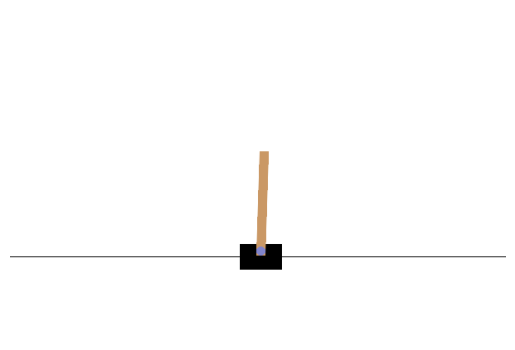

In [2]:
import gymnasium as gym
from utils import show_image
# Create the CartPole environment with 'rgb_array' mode
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Reset the environment
state,info = env.reset(seed=42)
print('Initial state:',state)
print('Initial info:',info)

# Render the environment and display the image
image = env.render()
show_image(image)

如果你成功看到了上面的输出和图片，那么恭喜你，你看到了环境`env`在初始化时的state $s_0$。根据gym的[官方文档](https://gymnasium.farama.org/environments/classic_control/cart_pole/)，这一环境的名字叫做`CartPole`，描述的是一个匀质杆一段铰接在一个置于光滑导轨的小车上。我们看到的`Initial state`中这四个参数的含义如下：
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

（注：`gym`包中管这个state叫做`observation`，比如`env.observation_space`实际上是state space的意思）。上面的结果是决定性的，因为我们手动设置了`seed`为42。接下来，让我们再看看action是什么：

In [3]:
env.action_space.seed(42)
env.observation_space.seed(42)
'action space',[env.action_space.sample() for _ in range(10)]

('action space', [0, 1, 1, 0, 0, 1, 0, 1, 0, 0])

根据官方文档，0代表向左推一下车，而1代表向右推一下。那么，假设对于初始的状态，我们连续地向右推，会变成什么样？

In [4]:
from utils import show_video
import numpy as np
frames = []
for t in range(100):
    image = env.render()
    frames.append(image)

    action = np.int64(1) # always take the "push right" action.
    next_state, reward, done, truncated, info = env.step(action) # 'step' is the function that gives the transition.
    state = next_state
    print('time stamp',t,'reward:',reward)
    if done or truncated:
        print('Stopped at timestamp',t,'due to','done' if done else 'truncated')
        break

show_video(frames)

time stamp 0 reward: 1.0
time stamp 1 reward: 1.0
time stamp 2 reward: 1.0
time stamp 3 reward: 1.0
time stamp 4 reward: 1.0
time stamp 5 reward: 1.0
time stamp 6 reward: 1.0
time stamp 7 reward: 1.0
time stamp 8 reward: 1.0
time stamp 9 reward: 1.0
Stopped at timestamp 9 due to done


很直观——如果我们一直推这一个车，杆就会向左倒下。此时，因为杆和竖直方向的夹角达到了某个临界值，`env`自动判断为游戏失败而结束。这就是`done`为`True`的原因。

同时，我们也可以看到`reward`的数值——对于每一个存活下来的一步，reward都是1。也就是说，我们的目的就是活得越长越好。

最后，让我们建立一个简单的agent，对这一任务作出一个难度上的基础感受。我们的`TrivialAgent`的思路很简单——如果杆偏左并且角速度向左，那么我们就往左推车；如果杆偏右并且角速度向右，那么我们就往右推车。最后，对于其他情况，因为这取决于未知的物理参数，我们不妨随机来选取action。这十分粗暴，但不妨让我们就看看它能做得怎样。

In [5]:
class TrivialAgent:

    def __init__(self,action_space):
        self.action_space = action_space
    
    def get_action(self,state):
        _,_,theta,omg = state
        if theta < 0 and omg < 0:
            return 0
        if theta > 0 and omg > 0:
            return 1
        return self.action_space.sample()

In [6]:
agent = TrivialAgent(env.action_space)
NUM_ROLLOUTS = 10
results = []
for rollout in range(NUM_ROLLOUTS):
    cum_reward = 0
    state,_ = env.reset()
    for t in range(1000):
        action = agent.get_action(state) # let our agent to decide what to do
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        cum_reward += reward
        if done or truncated:
            print('Terminate at time',t,'due to', 'done' if done else 'truncated')
            results.append(cum_reward)
            break
print('Average cumulative reward',sum(results)/len(results))
print('results:',results)

Terminate at time 499 due to truncated
Terminate at time 499 due to truncated
Terminate at time 347 due to done
Terminate at time 412 due to done
Terminate at time 395 due to done
Terminate at time 482 due to done
Terminate at time 499 due to truncated
Terminate at time 249 due to done
Terminate at time 499 due to truncated
Terminate at time 310 due to done
Average cumulative reward 420.1
results: [500.0, 500.0, 348.0, 413.0, 396.0, 483.0, 500.0, 250.0, 500.0, 311.0]


利用`TrivialAgent`，我们解锁了一个新“技能”——`truncated`！这个情况是因为环境具有一个有限的“**horizon**”，也就是到达这个时间后就会自动结束，类似于“游戏胜利”。这样，总的cumulative reward才有上限。我们看到，就这样一个愚蠢的agent就已经可以做到84%的最优解了！因此，这一任务确实是简单的。

我们还可以看到，不同组数据之间reward（即存活时间）可以相差很远——最大值是最小值的2倍！的确，你开始认识到RL了——一个接着一个的state迭代使得整个体系具有**巨大的方差**。我们后面会更加具体地讨论这一点。

最后，让我们欣赏一下我们的第一个“agent”的舞蹈，来结束这一小节吧！

In [7]:
frames = []
[env.reset() for _ in range(2)] # a tiny trick here :)
observation,_ = env.reset()
for t in range(1000):
    image = env.render()
    frames.append(image)

    action = agent.get_action(observation)
    next_state, reward, done, truncated, info = env.step(action)
    observation = next_state
    if done or truncated:
        print('Stopped at timestamp',t,'due to','done' if done else 'truncated')
        break

show_video(frames)

Stopped at timestamp 499 due to truncated


## 0.2 MDP Solvers

理解了MDP的概念之后，我们试着解决MDP问题。乍一看我们可能完全摸不到头脑：比如CartPole环境中，我们是基于一些基础的物理知识作出的判断；但假设我们的agent没有物理知识的输入，它如何能学会在这一个MDP中拿到高分呢？一开始的四个参数就如同“盲盒”一般，agent肯定需要学习一下他们代表什么含义，以及如何演化，最后才进行我们上面所作的“策略设计”。如何让一个机器完成这一切呢？

我们首先想到，一个主要的问题是环境的transition function和reward function都是完全未知的。倘若他们都是**已知的**，问题肯定会变得更简单：现在，相当于MDP作为一个透明的系统摆在我们面前，整个问题也就成为一个较为可控的问题。

### Values

这可能说起来略微抽象，但我们可以考虑如下的具体问题：在一个$4\times 4$的方格表里有一个特殊的格子，到达那里时游戏结束并且获得奖励5，而其他地方的奖励都是-1（为了督促你尽快到达终点而非随机乱走）。transition也很简单：在每一个格子(state)处，可以选择向一个方向走(action)，然后就走到了下一个state。（如果在终点那么不管如何走都到达end state）。

注意根据我们的假设，这个MDP是已知的，也就是我们知道那个特殊的格子在哪里。此时，如果不是agent而是人来解决这一问题，你该如何解决？很明显，你可以给出一个决定性的最优策略：假设我们在那个格子旁边的时候，我们就走过去；进一步，如果在再旁边一点的8个格子处，我们就走到前一次的4个格子……这样，递归地，如果确定了距离格子的Manhattan distance (定义为 $\text{MHT}((x_1,y_1),(x_2,y_2))=|x_1-x_2|+|y_1-y_2|$)为$n$的所有点的策略，那么距离格子为$n+1$的所有点的策略也就确定了。因此，我们可以给出一个完整的策略。给定一个具体的 $4\times 4$ 表格和那个特殊的格子，我们就可以给出这个最优策略。一个例子如下所示。

|$\rightarrow$ | $\rightarrow$ | $\downarrow$ | $\leftarrow$|
|--|--|--|--|
| $\rightarrow$| $\to$ | $\star$ | $\leftarrow$ |
|$\rightarrow$ | $\rightarrow$ | $\uparrow$ | $\leftarrow$ |
| $\rightarrow$| $\uparrow$ | $\uparrow$ | $\leftarrow$|

解决了这一问题，我们接下来试着把问题稍微一般化。假设transition并非像上面一样是确定的，而是**随机的**：在一个格子处向上走，只有70%的概率会真正走到上边——剩下的30%里，会随机走到周围剩余的格子里。注意这才是常态，因为我们在定义MDP的时候给出的就是transition probability $p(s'|s,a)$ 而非一个决定性的函数。我们接下来就来试着求解这一问题。

#### Value Iteration

那么，这样我们应该怎么办呢？容易想到，我们可以和上面完全类似地使用一种**递推关系**的方法解决这一问题。我们首先假设我们处于**最优的策略**；接下来，我们给每一个格子定义一个**价值**(value)，代表着如果我们是从这个格子出发，那么最好能达到多少分。很明显，我们有 $V(s_{\star})=5$，其中$s_\star$代表那个特殊的格子。而对于其他格子，我们则要试着把它的价值和周围几个格子的价值联系起来。

||B| | |
|--|--|--|--|
|C| A | $\star$ | |
| | D| |  |
| | | | |

让我们以格子$A$为例来研究。我们虽然不知道最优策略是什么，但是我们总可以假设他的一般形式：

$$
\pi^\star(a|s_A)=\begin{cases}\rightarrow&,\text{w.p. }p_1 \\\leftarrow&,\text{w.p. }p_2 \\ \uparrow&,\text{w.p. }p_3 \\ \downarrow&,\text{w.p. }p_4\end{cases}
$$

其中$\pi^\star$的$\star$代表这是最优策略。那么，我们就可以根据MDP和$V$的定义写出$V(A)$的表达式：

$$
\begin{align*}
V(s_A)&=p_1\left[-1+(70\%\times V(s_{\star})+10\%\times V(s_B)+10\%\times V(s_C)+10\%\times V(s_D))\right]\\
&\quad +p_2\left[-1+(70\%\times V(s_C)+10\%\times V(s_\star)+10\%\times V(s_B)+10\%\times V(s_D))\right]\\
&\quad +p_3\left[-1+(70\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C)+10\%\times V(s_D))\right]\\
&\quad +p_4\left[-1+(70\%\times V(s_D)+10\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C))\right]
\end{align*}
$$

但是我们又注意到$\pi^\star$是最优策略，因为这是我们的假设！因此，我们就可以“确定”下来$p_1,p_2,p_3,p_4$：一定是中括号里最大的那个action具有100%的概率，而其他都是0%概率。因此，我们就给出了：

$$
V(s_A)=-1+\max\Big\{70\%\times V(s_{\star})+10\%\times V(s_B)+10\%\times V(s_C)+10\%\times V(s_D),70\%\times V(s_C)+10\%\times V(s_\star)+10\%\times V(s_B)+10\%\times V(s_D), \\ 70\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C)+10\%\times V(s_D), 70\%\times V(s_D)+10\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C)\Big\}
$$

类似地，对于其他的每一个格子，我们都可以列出这样的一个方程。16个方程16个未知数，理论上一定可以求解；但是一系列max的存在使得这个问题变得有些复杂。一个投机取巧的方式是说，假设我们并不是直接求解，而是通过“赋值”的方式来近似求解呢？这就是**Value Iteration**算法的基本思想——看，你已经接触到了第一个RL算法！

让我们总结一下，并把上面的讨论一般化。我们给出**Value Iteration**：

> **Value Iteration Algorithm**

1. Init values $V(s)$ randomly for each state.
2. Repeat until convergence:
    - For each state $s$:
        - Update $V(s)$ by
        $$
        V(s)\leftarrow r(s,a)+\max_{a\in A}\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]
        $$

接下来，让我们就来把这一算法应用到上面提出的问题中吧！（为了使得代码简洁一些，我们把一些细节的内容放到了[utils_0_intro.py](./utils_0_intro.py)里面）

In [1]:
from utils_0_intro import Table
from utils import add_method_to_class

@add_method_to_class(Table)
def iteration(self:Table):
    """
    Perform the Value Iteration algorithm above for one step, and update `self.V`.
    """
    new_V = [[0]*self.size for _ in range(self.size)]
    for i in range(self.size):
        for j in range(self.size):
            if (i,j) == self.special:
                new_V[i][j] = 5
                continue
            l = []
            for action in self.get_possible_action((i,j)):
                weights = self.get_transition((i,j),action)
                l.append(sum([w*self.V[x][y] for (x,y),w in weights.items()]))
            new_V[i][j] = -1 + max(l) # The formula above
    self.V = new_V

t = Table()
t.display()

|0.00|0.00|0.00|0.00|
|-|-|-|-|
|0.00|0.00|0.00|0.00|
|0.00|0.00|0.00|0.00|
|0.00|0.00|0.00|0.00|

In [2]:
for time in range(21):
    t.iteration()
    if time % 5 == 0:
        print('Iteration',time)
        t.display()

Iteration 0


|-1.00|-1.00|-1.00|-1.00|
|-|-|-|-|
|-1.00|-1.00|5.00|-1.00|
|-1.00|-1.00|-1.00|-1.00|
|-1.00|-1.00|-1.00|-1.00|

Iteration 5


|0.02|1.07|2.95|1.66|
|-|-|-|-|
|0.30|2.76|5.00|2.95|
|-0.67|0.61|2.76|1.07|
|-2.74|-0.67|0.30|0.02|

Iteration 10


|0.36|1.62|3.03|2.04|
|-|-|-|-|
|1.04|2.86|5.00|3.03|
|-0.28|1.26|2.86|1.62|
|-1.22|-0.28|1.04|0.36|

Iteration 15


|0.47|1.64|3.05|2.05|
|-|-|-|-|
|1.08|2.90|5.00|3.05|
|-0.10|1.29|2.90|1.64|
|-1.13|-0.10|1.08|0.47|

Iteration 20


|0.48|1.65|3.05|2.06|
|-|-|-|-|
|1.09|2.90|5.00|3.05|
|-0.09|1.31|2.90|1.65|
|-1.09|-0.09|1.09|0.48|

可以发现，这个算法很快就收敛了！的确——在后面的讲中，我们会论证这一算法的收敛性。但接下来，有了这些value，我们应该如何计算我们需要的最优policy呢（还记得我们一开始假设自己处于最优policy，但求解的目标实际上是找到这个policy）？这其实也很简单，因为我们已经得到了结论，我们的action一定是最大化reward $r(s,a)$ 和next value $V(s')$ 的期望值的和。

这一过程也被称为**Policy Extraction**：

$$
\pi^\star(a|s)=\delta\left(a=\arg\max_{a\in A}\left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]\right)\right)
$$

其中$\delta$代表单点分布。

让我们实现这一点：

In [3]:
@add_method_to_class(Table)
def extract_action(self:Table):
    self.action = [[None]*self.size for _ in range(self.size)]
    for i in range(self.size):
        for j in range(self.size):
            if (i,j) == self.special:
                self.action[i][j] = '\\star'
                continue
            best_act = None
            best_val = -float('inf')
            for action in self.get_possible_action((i,j)):
                weights = self.get_transition((i,j),action)
                new_val = -1 + sum([w*self.V[x][y] for (x,y),w in weights.items()])
                if new_val > best_val:
                    best_val = new_val
                    best_act = action
            self.action[i][j] = self.get_display_str(best_act)

t.extract_action()
t.display(display_type='action')

|$\rightarrow$|$\rightarrow$|$\downarrow$|$\downarrow$|
|-|-|-|-|
|$\rightarrow$|$\rightarrow$|$\star$|$\leftarrow$|
|$\rightarrow$|$\uparrow$|$\uparrow$|$\uparrow$|
|$\uparrow$|$\uparrow$|$\uparrow$|$\uparrow$|

我们可以看到，这确实像是一个最优的策略。至此，我们就完成了Value Iteration方法的讨论，并第一次完整地解决了一个已知MDP下的问题！

#### What about a larger MDP?

上面的方法很直观，并且也很实用。但是，好景不长——在上面的问题里，state space的大小是16。但如果你的梦想是像Alpha Go一样处理围棋，你常见的state space可能是超过$10^{100}$以上！对于这样庞大的state space，就算在宇宙中的每一粒原子上都写下一个value，也不够储存。更为甚者，如果我们处理像之前CartPole一样的问题，我们的state是连续的，就更是无从下手了。

但当我们想到这里的时候，我们一下子就发现了——我们可以使用DL中的技术，**用一个神经网络近似$V(s)$** ！这个网络输入$s$，输出对应的value。考虑到神经网络的“压缩”作用（想想ChatGPT这一模型的大小肯定比它的训练数据加起来小很多倍！），我们就可以处理大规模的MDP问题了。上面的算法中不需要修改任何地方——只需要在更新的时候把赋值换为梯度下降就可以了。（当然，如果具体实现起来可能有很多细节，比如为了避免直接训练这样`batch=1`的不稳定，我们需要采集很多数据再做一波训练，等等）

但敏锐的你可能会发现其中的漏洞：神经网络的拟合本身会带来一个误差。此时，如果依然采用迭代的方法，我们真的还能保证收敛吗？残酷的现实是：**不**。这样的方法（也称为**fitted Value iteration**）并没有一个收敛的保证。实际上，它们不仅理论上不收敛，在实验上也展现着很大的方差。

#### Experiment: Pixel Game

我们可以再实操一个例子：“玩像素”（Pixel Game）。我们有一个$10\times 10$的方格表，其中有22个棋子（也就是“像素”）是我们可以操控的。我们希望这些像素排成一个指定的汉字："**兵**"。

一开始，我们的所有棋子随机排布；而对于每一个state，我们可以采取一个action $(x,y,d)$，其中$(x,y)$代表需要移动的棋子的位置（如果没有棋子那么无效）；而$d$和之前一样是0,1,2,3中的一个，代表上下左右移动（如果无法移动那么也无效）。为了简化问题，我们认为transition是确定的，就是按照方向$d$移动$(x,y)$处的棋子后的整个像素排布。最后，reward $r(s,a)$ 取为只和$s$有关。假设$s$和最终target image的共同像素数（不计算重数）是$N$，那么

$$
r(s,a)=\begin{cases}\frac{N-22}{220}&,N<22\\100&,N=22\end{cases}
$$


In [1]:
from utils_0_intro import PixelGame
from utils import add_method_to_class
pgame = PixelGame()
print('Target image:')
pgame.display_target()
print('Our initial state:')
pgame.display(pgame.reset(randomly=True))
print('Initial reward',pgame.get_reward())

Your device is cpu
Target image:


| | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█| | | | |
| | | | |█| | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| |█|█|█|█|█|█|█|█| |
| | | |█| |█| | | | |
| | |█| | | |█| | | |
| | | | | | | | | | |

Our initial state:


|█| |█| | | | | |█| |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | |█|
| |█|█| | | | |█| | |
| | | | | | | | | | |
| | |█| | | | | | | |
|█| | | |█| | | |█| |
| | | |█|█| | |█| |█|
| | | |█| | | | | | |
|█| | | | | | | | |█|
| | | | | | | | | | |

Initial reward -0.08181818181818182


接下来，我们就来设计一个简单的网络$V(s)$。

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader,Dataset

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=16,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3)
        self.mlp = nn.Linear(128,1)

    def forward(self,x):
        """
        compute the estimated Value given state `x`.
        """
        x = nn.LeakyReLU(0.1)(self.conv1(x))
        x = nn.LeakyReLU(0.1)(self.conv2(x))
        x = nn.LeakyReLU(0.1)(self.conv3(x))
        x = x.reshape(x.shape[0],-1)
        return self.mlp(x)

接下来，我们来准备训练数据。回顾一下我们的训练过程是

$$
V(s)\leftarrow \max_{a\in A}\left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]\right)
$$

这里唯一的变量是$s$。对于哪些$s$做这一更新呢？可以对于所有$s$，但这不现实——这一问题的state space大小是$10^{30}$左右的量级。我们为了充分利用fitted value iteration的优势，我们必须只选取相对少的一些state来训练。

那如何选取这些state呢？我们发现，这些state要**具有代表性**。比如最极端地，如果没有任何一个state有着非零的reward，我们的网络就不可能学到任何东西。因此，我们决定根据他们的**分数**（也就是和目标图案重复的pixel个数）来选取数据。

In [3]:
import random

@add_method_to_class(PixelGame)
def sample_given_score(self:PixelGame,match_num,sample_num=200):
    """
    Sample some states given `match_num`.

    Args:
        `match_num`: the number of states that match the target image.
        `sample_num`: the number of states to sample.
    """
    other_pixels = [(i,j) for i in range(10) for j in range(10) if (i,j) not in self.target_pixel_pos]
    states = []
    for _ in range(sample_num):
        common = random.sample(self.target_pixel_pos,match_num)
        others = random.choices(other_pixels + common,k=22-match_num) # can choose in common since it doens't count
        states.append(common + others)
    return states

states = []
for match_num in range(23):
    states.extend(pgame.sample_given_score(match_num=match_num))
print('Gathered states:',len(states))

Gathered states: 4600


接下来，我们考虑训练过程。回顾一下，最外围的循环是Value iteration，就像之前那样；而和之前不同的是，我们在内部又添加了一个神经网络拟合的循环。

一个必须讨论的细节是，为了发挥optimizer的优势，我们应该不是一组一组数据训练，而是把训练数据收集起来并用batch来训练。为此，我们编写一个函数`get_dataloader`。

In [4]:
# first load the transitions once
print('Storing transitions, this may take around a minute...')
transition_datas = []
for state in states:
    actions = pgame.get_actions(state)
    nexts = []
    terminated = False
    for action in actions:
        next_state = pgame.get_transition(state,action)
        if next_state is None:
            terminated = True
            break
        nexts.append(pgame.as_tensor(next_state))
    transition_datas.append({
        'state':state,
        'next_states':torch.stack(nexts,dim=0) if not terminated else None,
        'terminated':terminated
    })
len(transition_datas)

Storing transitions, this may take around a minute...


4600

In [5]:
from utils import device

@torch.no_grad()
def get_dataloader(net:Net):
    dataset = []
    for it in transition_datas:
        state = it['state']
        target = pgame.get_reward(state)
        term = it['terminated']
        if not term:
            target += net(it['next_states'].to(device)).max(dim=0)[0].cpu().item()
        dataset.append((state,target))
    return DataLoader(dataset=dataset,batch_size=128,shuffle=True,
    collate_fn=lambda datas:
        {
            'states': torch.stack([pgame.as_tensor(data[0]) for data in datas],dim=0),
            'targets':torch.tensor([data[1] for data in datas],dtype=torch.float).unsqueeze(-1)
        }
    )

注意，这里的`terminated`变量处理了一个特殊情况：如果已经到了最终的state $s_\star$，那么没有下一个transition，而且value的训练目标就是$r(s_\star)=100$。

最后，我们可以开始了！

In [6]:
pick_state = states[len(states)//2] # here we select a state to monitor the convergence of value iteration.
values_for_that_state = []
print('We use this random state to monitor the value:')
pgame.display(pick_state)

We use this random state to monitor the value:


| | | | | |█| | | | |
|-|-|-|-|-|-|-|-|-|-|
| |█|█| | |█| | | | |
| | | | | | |█| | | |
| | | |█| | | | | | |
| | | |█|█| |█| | | |
| | | |█| | | | | | |
| | |█| |█| |█|█|█|█|
| |█| | | | | |█| | |
| |█| | | | | | | | |
| | | | | |█|█| | | |

In [57]:
from tqdm import tqdm
net = Net().to(device)
opt = Adam(net.parameters(),lr=5e-3)
values_for_that_state = []
for iteration in range(25):
    losses = []
    dataloader = get_dataloader(net)
    with tqdm(dataloader) as bar:
        for it in bar:
            val = net(it['states'].to(device)) # [batch,1]
            loss = F.mse_loss(val,it['targets'])
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Iteration {iteration}: loss {sum(losses)/len(losses):.4f}')
    with torch.no_grad():
        value = net(pgame.as_tensor(pick_state).unsqueeze(0).to(device)).cpu().item()
    if iteration % 5 == 0:
        print('Value of the specific state',value)
    values_for_that_state.append(value)

Iteration 0: loss 378.9311: 100%|██████████| 36/36 [00:01<00:00, 30.80it/s]


Value of the specific state 0.3292299509048462


Iteration 5: loss 6.9925: 100%|██████████| 36/36 [00:01<00:00, 26.57it/s] 


Value of the specific state 22.306779861450195


Iteration 10: loss 11.7262: 100%|██████████| 36/36 [00:01<00:00, 28.60it/s]


Value of the specific state 69.13394927978516


Iteration 15: loss 83.2631: 100%|██████████| 36/36 [00:01<00:00, 26.81it/s] 


Value of the specific state 118.82010650634766


Iteration 20: loss 917.9474: 100%|██████████| 36/36 [00:01<00:00, 28.52it/s] 


Value of the specific state 208.20388793945312


Iteration 24: loss 2916.3315: 100%|██████████| 36/36 [00:01<00:00, 26.68it/s]


我们还可以观察一下整个过程中value整体上是如何变化的：

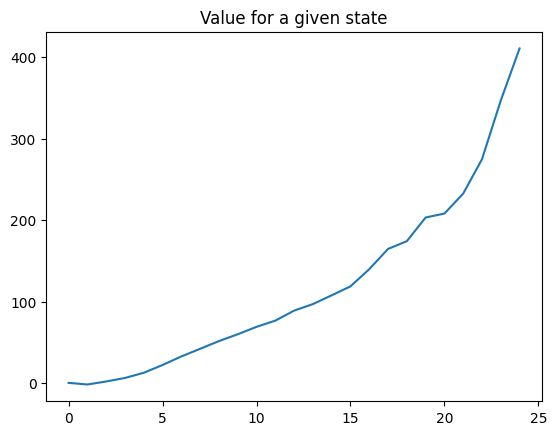

In [58]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in enumerate(values_for_that_state)],values_for_that_state)
plt.title('Value for a given state')
plt.show()

可以发现，value虽然开始有所涨落，但之后上升的很快。我们再来看看给出的策略如何？

In [7]:
def demonstrate_policy(net):
    state = pgame.reset(randomly=True)
    cum_r = 0
    succeed = False
    print('Initial state:')
    pgame.display()
    print('Initial common pixels',pgame.get_common_pixels(state))
    for time in range(200):
        actions = pgame.get_actions(state)
        best_act = None
        best_val = float('-inf')
        for action in actions:
            next_state = pgame.get_transition(state,action)
            with torch.no_grad():
                value = net(pgame.as_tensor(next_state).unsqueeze(0).to(device)).cpu().item()
            if value > best_val:
                best_val = value
                best_act = action
        cum_r += pgame.get_reward(state)
        state = pgame.get_transition(state,best_act)
        if state is None:
            succeed = True
            break
        pgame.set_state(state)
        if time % 20 == 1:
            print('t =',time)
            pgame.display()
    print('Cumulative reward',f'{cum_r:.2f}')
    print('Succeeded?',succeed)
    print('Final common pixels:',100 if succeed else pgame.get_common_pixels(state))
    return state

In [60]:
demonstrate_policy(net)

Initial state:


| |█| |█| | |█| | |█|
|-|-|-|-|-|-|-|-|-|-|
| | |█| | | |█|█| | |
| |█| | | | | | | | |
| |█| | | | | | | | |
| | | | |█| |█|█| | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
|█| | | | | |█|█| |█|
| | | | | | | | | | |

Initial common pixels 5
t = 1


| |█| |█| | |█| | |█|
|-|-|-|-|-|-|-|-|-|-|
| | |█| | | |█|█| | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | |█| |█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
|█| | | | | |█|█| |█|
| | | | | | | | | | |

t = 21


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 41


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 61


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 81


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 101


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 121


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 141


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 161


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 181


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

Cumulative reward -18.08
Succeeded? False
Final common pixels: 2


我们发现我们的网络竟然什么都没有学到——最后的common pixel个数竟然少于一开始的！这显然说明了网络的价值评估出现了错误。再一回味，也又发现了问题：无论如何，value都不应该到达100以上，因为最终的state才有reward 100，而其他的state reward都为负数。一定是有地方出了问题！

哈哈，的确——提出理论只需要凭感觉就可以了，但做实验的人需要想的就多了。我们只能观察：可以发现，**随着value的大幅度上升，loss也增加了**，如何解释这件事呢？

其实，道理很简单——为什么在一个iteration内部我们的loss不能降到0？我们的神经网络表达能力肯定还是够的，真正的问题在于**数据太差**。为什么数据差？原因也很简单，因为value iteration的中间结果可能有一定波动，这些波动在不同的state上体现不一样，而value又间接地被当成训练数据，这就好比是训练数据上下了毒一般。更糟糕的是，这样训练出来的糟糕模型又被当成下一次训练的目标，这样loss就会爆炸一般大幅上升。

一个很好的比喻是说，上面的方法宛如**shooting a moving target**。我们的DL模型之所以强大，是因为他们狠狠地在固定的靶子上训练并达到极高的水准；而现在把他们应用到这里可能令他们有些水土不服。为何不让靶子**停下来**，或者**慢下来**呢？这就是**target network**的基本思想。

#### Target Network

首先，我们引入一个**target network** $V_{\theta_0}$，而把原来的网络叫做$V_\theta$。其次，我们的更新方式就变成了

$$
\theta \leftarrow \theta + \eta \nabla_{\theta}\left[V_\theta(s)-\left(\max_{a\in A}\left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V_{\theta_0}(s')]\right)\right)\right]^2
$$

顾名思义——target network就用于target的计算。回顾之前的方法，相当于target network被取为前一个Iteration更新后的$V$，瞬息万变；而现在，我们希望target network的更新慢一些。

第一个方法就是，我们**隔一段时间猛地更新一下**：

```python
if iteration % PERIOD == 0:
    target_net.load_state_dict(net.state_dict())
```

而第二个方法更加文明：我们每一次使用running average更新。也就是说：

$$
\theta_0 \leftarrow (1-\alpha)\theta_0 + \alpha \theta
$$

这稍微更难实现一些，但更稳定（可以想象），因此我们采用这第二种方法。

In [8]:
from tqdm import tqdm
net = Net().to(device)
target_net = Net().to(device).requires_grad_(False)
target_net.load_state_dict(net.state_dict())
opt = Adam(net.parameters(),lr=5e-3)
values_for_that_state = []
ALPHA = 0.2
def update_target():
    for theta_0,theta in zip(target_net.parameters(),net.parameters()):
        theta_0.copy_((1-ALPHA) * theta_0 + ALPHA * theta)

def continue_train_one(iteration):
    losses = []
    dataloader = get_dataloader(target_net)
    with tqdm(dataloader) as bar:
        for it in bar:
            val = net(it['states'].to(device)) # [batch,1]
            loss = F.mse_loss(val,it['targets'])
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Iteration {iteration}: loss {sum(losses)/len(losses):.4f}')
    update_target()
    with torch.no_grad():
        value = net(pgame.as_tensor(pick_state).unsqueeze(0).to(device)).cpu().item()
    if iteration % 5 == 0:
        print('Value of the specific state',value)
    values_for_that_state.append(value)

for iteration in range(50):
    continue_train_one(iteration)

  0%|          | 0/36 [00:00<?, ?it/s]/home/zhh/anaconda3/envs/DYY/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Iteration 0: loss 380.1263: 100%|██████████| 36/36 [00:02<00:00, 13.60it/s]


Value of the specific state -1.7006075382232666


Iteration 5: loss 86.3560: 100%|██████████| 36/36 [00:01<00:00, 27.91it/s]


Value of the specific state 0.17137743532657623


Iteration 10: loss 19.5462: 100%|██████████| 36/36 [00:01<00:00, 22.96it/s]


Value of the specific state 0.6864661574363708


Iteration 15: loss 10.9364: 100%|██████████| 36/36 [00:01<00:00, 28.46it/s]


Value of the specific state 0.815923810005188


Iteration 20: loss 8.5178: 100%|██████████| 36/36 [00:01<00:00, 27.76it/s]


Value of the specific state 1.3873649835586548


Iteration 25: loss 7.2592: 100%|██████████| 36/36 [00:01<00:00, 24.90it/s]


Value of the specific state 1.7577736377716064


Iteration 30: loss 5.1560: 100%|██████████| 36/36 [00:01<00:00, 26.31it/s]


Value of the specific state 2.6860718727111816


Iteration 35: loss 4.4488: 100%|██████████| 36/36 [00:01<00:00, 28.06it/s]


Value of the specific state 3.428640842437744


Iteration 40: loss 2.7099: 100%|██████████| 36/36 [00:01<00:00, 25.74it/s]


Value of the specific state 4.623112201690674


Iteration 45: loss 3.5135: 100%|██████████| 36/36 [00:01<00:00, 27.05it/s]


Value of the specific state 5.84722900390625


Iteration 49: loss 2.2010: 100%|██████████| 36/36 [00:01<00:00, 24.71it/s]


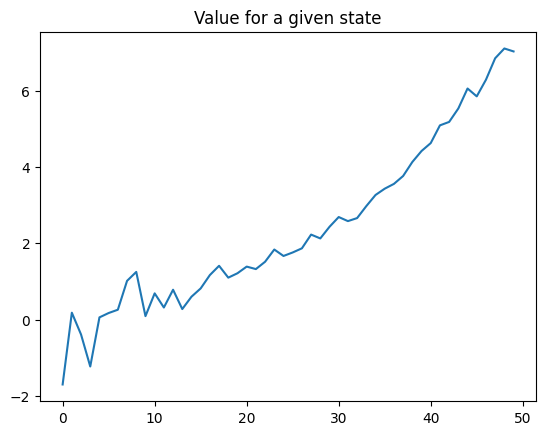

In [11]:
plt.plot([x[0] for x in enumerate(values_for_that_state)],values_for_that_state)
plt.title('Value for a given state')
plt.show()

看起来不错！之前loss随着value增大的逐渐上升现象消失了。让我们继续吧！

当然，看到value一直在上升，我们也要大概心里有个概念：value的理论值大概是多少？上限肯定是100；而下限可以简单地估算：$100-0.1\times (20\times 22)=56$，其中$20\times 22$是最大可能的操作步数。因此，最终的value应该在二者之间才合理。

In [12]:
for iteration in range(50,100):
    continue_train_one(iteration)

Iteration 50: loss 3.6074: 100%|██████████| 36/36 [00:01<00:00, 33.18it/s]


Value of the specific state 7.542821884155273


Iteration 55: loss 3.4566: 100%|██████████| 36/36 [00:01<00:00, 28.92it/s]


Value of the specific state 10.080211639404297


Iteration 60: loss 4.8317: 100%|██████████| 36/36 [00:01<00:00, 26.15it/s]


Value of the specific state 14.747027397155762


Iteration 65: loss 6.7890: 100%|██████████| 36/36 [00:01<00:00, 27.52it/s]


Value of the specific state 18.557485580444336


Iteration 70: loss 6.9507: 100%|██████████| 36/36 [00:01<00:00, 23.81it/s]


Value of the specific state 24.748151779174805


Iteration 75: loss 10.7839: 100%|██████████| 36/36 [00:01<00:00, 27.41it/s]


Value of the specific state 33.13731384277344


Iteration 80: loss 13.6706: 100%|██████████| 36/36 [00:01<00:00, 25.63it/s]


Value of the specific state 45.65507125854492


Iteration 85: loss 14.7042: 100%|██████████| 36/36 [00:01<00:00, 26.50it/s]


Value of the specific state 53.035179138183594


Iteration 90: loss 19.6893: 100%|██████████| 36/36 [00:01<00:00, 26.06it/s]


Value of the specific state 60.28752136230469


Iteration 95: loss 29.9398: 100%|██████████| 36/36 [00:01<00:00, 25.15it/s]


Value of the specific state 70.80062103271484


Iteration 99: loss 46.8109: 100%|██████████| 36/36 [00:01<00:00, 26.68it/s]


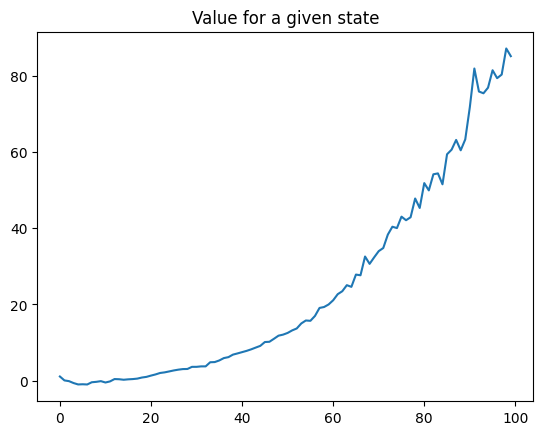

In [15]:
plt.plot([x[0] for x in enumerate(values_for_that_state)],values_for_that_state)
plt.title('Value for a given state')
plt.show()

糟了——就在最后几个iteration里，value又和loss一起起飞了。我们没有从根本上解决这个问题，但不妨先看看效果如何：

In [13]:
last_state = demonstrate_policy(net)

Initial state:


|█| | | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| |█| |█| | |█| | | |
| |█|█| |█| | |█| | |
| | |█| | | |█| | |█|
| | | | | | | | | |█|
| | | | | | | | | | |
| | | | | |█|█| | | |
| |█| | | | |█| | | |
| | | | | | | | | | |
| | | | |█|█| | | | |

Initial common pixels 3
t = 1


|█| | | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| |█| |█| | | | | | |
| |█|█| |█| |█|█| | |
| | |█| | | |█| | |█|
| | | | | | | | | |█|
| | | | | | | | | | |
| | | | | |█|█| | | |
| |█| | | | | | | | |
| | | | | | | | | | |
| | | | |█|█| | | | |

t = 21


|█| | | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| |█| | | | | | | | |
| |█| | |█| | |█| | |
| | | |█| | |█| | |█|
| | | |█|█| | | | |█|
| | | | | | | | | | |
| | |█| |█|█|█| | | |
| | | |█| | | | | | |
| | | | | | | | | | |
| | | | |█| | | | | |

t = 41


|█| | | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| |█| | | | | | | | |
| |█| | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█| | |█|
| | | |█| |█| | | |█|
| | | |█|█|█|█| | | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 61


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 81


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 101


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 121


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 141


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 161


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

t = 181


| |█| | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | | |
| | | | |█| | | | | |
| | | |█| |█|█| | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | | | | | | | |
| | | | | | | | | | |

Cumulative reward -7.17
Succeeded? False
Final common pixels: 16


模型的确取得了很大的进步，但还没有排“兵”布阵的能力。但接下来，我们该何去何从呢？

我们可以先以上面的最后一张图片为例子，看看为什么这个过程进行不下去了？

In [14]:
actions = pgame.get_actions(last_state)
lst = []
for a in actions:
    lst.append((a,net(pgame.as_tensor(pgame.get_transition(last_state,a)).unsqueeze(0).to(device)).item()))
print(sorted(lst,reverse=True,key=lambda x: x[1])[:5])

[((0, 1, 1), 236.60252380371094), ((0, 7, 1), 236.60252380371094), ((0, 1, 3), 236.34033203125), ((0, 1, 2), 235.5745391845703), ((0, 1, 0), 235.56044006347656)]


我们发现，排名前几名的action，其对应的value都很接近！在这样的情况下，模型自身近似造成的误差就已经远大于不同action之间的“区分度”，而在这里模型恰好选择了一个不做任何操作的action，这样他就被“卡住”了。

同时，我们看到Value的数值又是超过了100！的确，神经网络的本质让这没有任何办法——神经网络的输出是十分“凹凸不平”的，就算整体上Value小于100,也肯定有一些奇怪的地方Value非常巨大。在这些地方Value网络的准确度更是完全没法保证。

为了解决这一问题，我们其实可以从根本上反思Value Iteration这一方法：还记得之前我们如何引入Value这一概念的吗？当时我们假设自己处于最优策略，并据此给出每一个点处的“价值”，满足一个递推关系。然后，我们设法求解这个递推关系得到一个Value的近似值。最后，我们再做policy extraction。在这一过程中，Value毕竟只是一个媒介。我们自然地想到：我们是否可以**不经过Value这一层，直接优化policy**呢？

从直觉上，这样非常好——因为policy直接就是我们想要的东西，就没有必要比较不同的Value，神经网络的拟合误差也就不会被放大。这就是Policy-based method的本质性优点，下面我们就来探讨它们。

### Policy-based Methods

如何直接优化policy呢？我们从定义出发：

$$
J(s)=\mathbb{E}_{a\sim \pi(a|s)}\left[r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}\left[\mathbb{E}_{a'\sim \pi(a'|s')}[r(s',a')+\cdots]\right]\right]
$$

为了记号方便，我们记$\tau$为**轨迹**(trajectory)，也就是$s,a,s',a',\cdots$不断下去。我们可以用$\tau$的概率分布代替：

$$
p(\tau|s)=\pi(a|s)p(s'|s,a)\pi(a'|s')\cdots
$$

$$
J(s)=\mathbb{E}_{\tau\sim p(\tau|s)}\left[\sum_{t=0}^{T}r(s_t,a_t)\right]
$$

其中，记号$s_0,a_0,s_1,a_1,\cdots$定义为和$s,a,s',a',\cdots$一一对应（也就是$s_0:=s,a_0:=a$，依次类推）。$T$是horizon，也就是在这么多步后立刻结束；这个变量通常在实验中设置，以避免运行周期过长或者总reward发散。这样，这个MDP问题就变成了**找到一个函数$\pi(a|s)$，使得目标函数$J$最大化**。（$J$可以理解为$J(s)$对$s$的平均）这样一个函数优化问题。

#### Policy Gradients

诚然，可以把$\pi$像之前一开始尝试Value Iteration的时候那样写为表格(tabular)形式；但我们还是更希望讨论一般的情况，这时我们应该使用神经网络来表达$\pi$：$\pi_\theta$。一个想法是，我们能否 **直接对 $J$ 求$\theta$的梯度**？假设$\pi$由参数$\theta$决定，那么：

$$
\nabla_\theta J(\theta)=\nabla_\theta \sum_{\tau}p(\tau)\left(\sum_{t=0}^{T}r(s_t,a_t)\right)
$$

很明显，只有$p(\tau|s)$里面含有对$\theta$的梯度。因为对乘积求导数，所以自然采用对数求导：

$$
\begin{align*}
\nabla_\theta J(\theta)&=\sum_{\tau}p(\tau)\left(\sum_{t=0}^T \nabla_\theta\log \pi_\theta(a_t|s_t)\right)\left(\sum_{t=0}^{T}r(s_t,a_t)\right)\\
&=\mathbb{E}_{\tau\sim p(\tau)}\left[\left(\sum_{t=0}^T \nabla_\theta\log \pi_\theta(a_t|s_t)\right)\left(\sum_{t=0}^{T}r(s_t,a_t)\right)\right]
\end{align*}
$$

注意到最后又写成了期待值的形式——这意味着可以使用采样的方法估计。为何一定要采样？因为如果严格计算，那么计算量随着时间指数级别地增长，完全无法控制。

这就是著名的**Policy Gradients**方法。你可能会惊叹：这一表达式竟然如此简单，我们只需要采样并梯度下降就可以完成MDP问题的求解了！的确如此，但在实现的地方需要小心：这里的采样$p(\tau)$也和policy $\pi$有关。因此，每做一次gradient step，就要重新做一次采样。这样，我们就给出了算法：

> (Vanilla) **Policy Gradient Algorithm**
>
> 不断重复：
> 1. 采集若干trajectory $\tau\sim p(\tau)$
> 2. 计算梯度并作gradient step。

我们很容易就可以实现这一方法。就让我们在Pixel Game上一雪前耻吧！

In [8]:
from utils import device
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils_0_intro import PixelGame
pgame = PixelGame()

当然，还有一些必须注意的细节。首先是为了利用optimizer，我们不应该直接计算梯度，而是搞一个**fake loss**来backward，这个loss就可以选取为

$$
J_{\text{fake}}=\mathbb{E}_{\tau\sim p(\tau)}\left[\left(\sum_{t=0}^T\log \pi_\theta(a_t|s_t)\right)\left(\sum_{t=0}^{T}r(s_t,a_t)\right)\right]
$$

此外，为了计算方便，我们让模型输出对400个完整action的logit，最后再通过`action_mask`选取出有意义的action。

In [9]:
class PolicyGrad(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=8,kernel_size=3,padding=1)
        self.rev1 = nn.ConvTranspose2d(in_channels=8,out_channels=64,kernel_size=3,padding=1)
        self.rev2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,padding=1)
        self.mlp = nn.Conv2d(in_channels=32,out_channels=4,kernel_size=1)

    def forward(self,x):
        f1 = F.relu(self.conv1(x))
        f2 = F.relu(self.conv2(f1))
        rev1 = F.relu(self.rev1(f2)) + f1
        rev2 = F.relu(self.rev2(rev1)) + x
        return self.mlp(rev2).reshape(x.shape[0],-1) # logits
    
    def get_action(self,x,action_mask):
        logits = self(x)
        return torch.distributions.Categorical(logits=logits + action_mask).sample()
    
    def get_prob(self,x,a,action_mask):
        # notice that both a and x is batched, and a has shape [batch]
        logits = self(x)
        probs = torch.softmax(logits + action_mask,dim=-1)
        return probs[torch.arange(a.shape[0]),a]

In [10]:
def act2ind(a):
    x,y,d = a
    return 4*(10*x+y)+d

def ind2act(ind):
    d = ind % 4; rem = ind // 4
    return rem//10, rem%10, d

def build_action_mask(actions):
    msk = torch.empty(400)
    msk.fill_(-1e6)
    msk[[act2ind(a) for a in actions]] = 0
    return msk.to(device)

def collect_rollout(agent:PolicyGrad,horizon=50):
    state = pgame.reset(randomly=True)
    states = [];actions = [];rewards = [];truncates = [];action_masks = []
    for t in range(horizon):
        tensor_state = pgame.as_tensor(state)
        possible_actions = pgame.get_actions(state)
        action_mask = build_action_mask(possible_actions)
        action = agent.get_action(tensor_state.to(device),action_mask=action_mask)

        states.append(tensor_state)
        action_masks.append(action_mask)
        actions.append(action)
        rewards.append(pgame.get_reward(state))
        truncates.append(False)

        state = pgame.get_transition(state,ind2act(action.cpu().item()))
        if state is None: # win before horizon
            need_add = horizon - len(states)
            states += [torch.zeros_like(states[0])] * need_add
            actions += [0] * need_add
            rewards += [0] * need_add
            truncates += [True] * need_add
            action_masks += [torch.zeros_like(action_masks[0])] * need_add
    return states,actions,rewards,truncates,action_masks

def get_dataloader(agent:PolicyGrad,num_rollouts=1000):
    def collate(datas):
        out_states = [];out_acts = [];out_rews = [];out_truncated = [];out_action_masks = []
        for data in datas:
            states,actions,rewards,truncated,action_masks = data
            out_states.append(torch.stack(states)) # item: [T,1,10,10]
            out_acts.append(torch.stack(actions).int()) # item: [T,1]
            out_rews.append(sum(rewards)) # item: float
            out_truncated.append(torch.tensor(truncated,dtype=torch.float)) # item: [T]
            out_action_masks.append(torch.stack(action_masks)) # item: [T, 400]
        return {
            'states': torch.stack(out_states), # [batch,T,1,10,10]
            'actions':torch.stack(out_acts), # [batch,T,1]
            'rewards':torch.tensor(out_rews), # [batch]
            'truncated':torch.stack(out_truncated), # [batch,T]
            'actmask': torch.stack(out_action_masks) # [batch,T,400]
        }
    dataset = []
    with tqdm(range(num_rollouts),desc='Sampling Trajectories') as bar:
        for _ in bar:
            dataset.append(collect_rollout(agent))
    return DataLoader(dataset=dataset,batch_size=32,collate_fn=collate)

开始训练！注意，没有GPU的话sample trajectory可能会很慢。

Iteration 0: loss nan, avg cum-reward: -4.0523: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]       


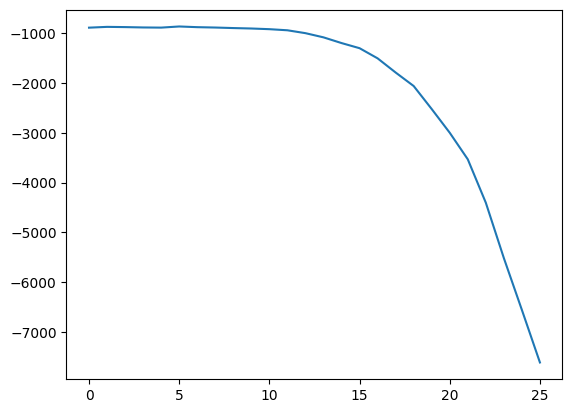

Sampling Trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Expected parameter logits (Tensor of shape (1, 400)) of distribution Categorical(logits: torch.Size([1, 400])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SubBackward0>)

In [12]:
agent = PolicyGrad().to(device)
optimizer = torch.optim.Adam(agent.parameters(),lr=1e-3)
for iteration in range(20):
    dataloader = get_dataloader(agent)
    with tqdm(dataloader) as bar:
        losses = []
        tot_cum_reward = 0
        tot_cnt = 0
        for item in bar:
            states = item['states'].to(device);actions = item['actions'].to(device);rewards = item['rewards'].to(device);truncated = item['truncated'].to(device);act_masks = item['actmask'].to(device)
            tot_cnt += rewards.shape[0]
            tot_cum_reward += rewards.sum(dim=0)
            probs = agent.get_prob(states.reshape(-1,1,10,10) , actions.reshape(-1),action_mask=act_masks.reshape(-1,400)).reshape(states.shape[0],-1) # [batch,T]
            j = (probs.log() * (1-truncated)).sum(dim=-1) * (rewards)
            optimizer.zero_grad()
            loss = -j.mean(dim=0)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Iteration {iteration}: loss {sum(losses)/len(losses):.4f}, avg cum-reward: {tot_cum_reward/tot_cnt:.4f}')
        plt.plot(list(range(len(losses))),losses)
        plt.show()

完了！怎么出现了nan？别急，如果你观察到了绘制出来的曲线，那么你会发现它并非一个健康的MLE曲线，因为他画的是loss，却是上凸的。仔细一想，就发现问题了：我们采集到的所有数据的reward都是负数，这样就导致我们的$\nabla_\theta J$实际上是最小化一个log likelihood，这可以到达无限小！

你可能会奇怪，但是理论上policy gradient方法是正确的啊？的确，原来并非纯粹地最小化log likelihood，因为也有地方reward为正。只不过在实践中，我们的随机policy很难采样到最后那个100的reward，即使采样到了也不会被重视。这样，就出现了上面训练崩溃的问题。

#### Reward Normalizing

如何解决这一困境呢？也好办：我们在训练前，先**把reward进行一个normalize**。也就是把一个Batch里面的cumulative reward变成均值0,方差1。为什么可以这样做？首先，我们可以注意到

$$
\mathbb{E}_{\tau\sim p(\tau)}\left[\left(\sum_{t=0}^T \nabla_\theta\log \pi_\theta(a_t|s_t)\right)\cdot b\right] = \sum_{\tau}p(\tau)\nabla_\theta \log p(\tau)=0
$$

因此，我们可以在$\sum_{t=0}^T r(s_t,a_t)$上减去任意一个bias $b$；而再除以方差$\sigma$只不过是调整一下learning rate。因此，这一操作完全可行。

让我们来试一试：

Sampling Trajectories: 100%|██████████| 1000/1000 [00:44<00:00, 22.44it/s]
Iteration 0: loss 1.3000, avg cum-reward: -4.0574: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


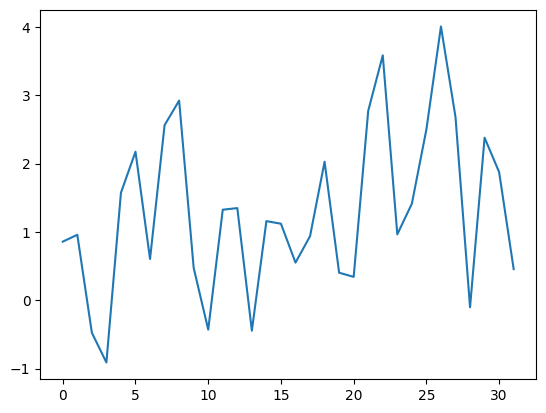

Sampling Trajectories: 100%|██████████| 1000/1000 [00:52<00:00, 18.99it/s]
Iteration 1: loss 1.6304, avg cum-reward: -4.0399: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


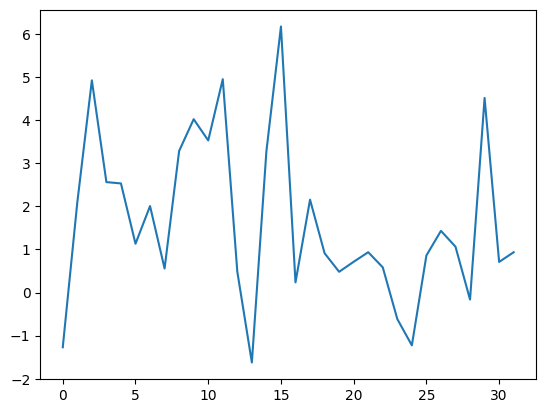

Sampling Trajectories: 100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s]
Iteration 2: loss 1.7789, avg cum-reward: -4.0309: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


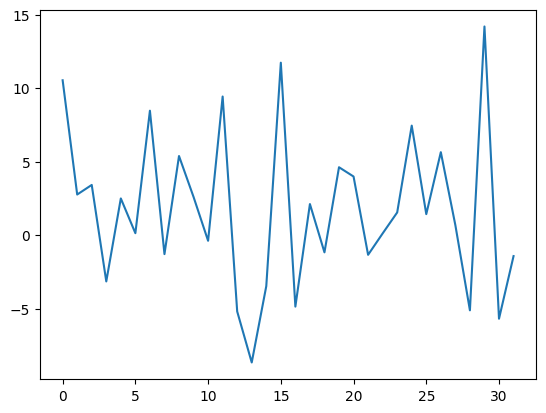

Sampling Trajectories: 100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]
Iteration 3: loss 3.4793, avg cum-reward: -3.9929: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


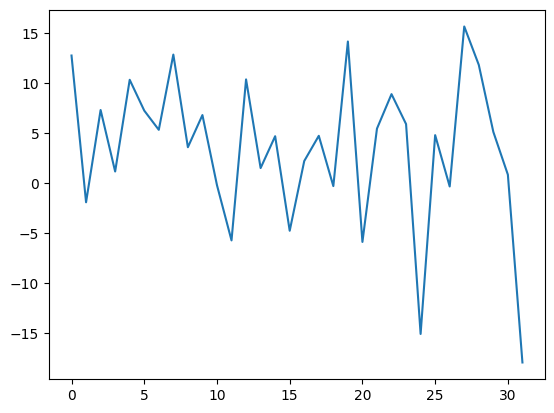

Sampling Trajectories: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]
Iteration 4: loss -6.7131, avg cum-reward: -4.0405: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


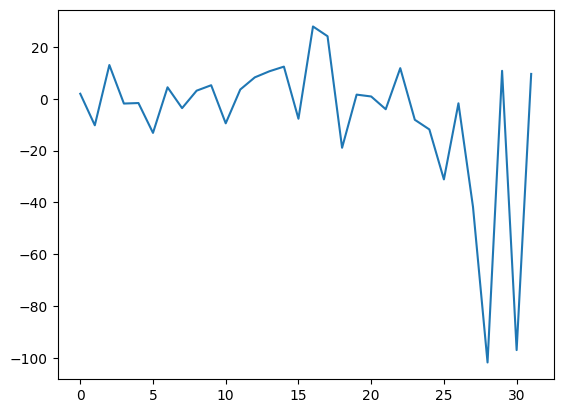

In [31]:
agent = PolicyGrad().to(device)
optimizer = torch.optim.Adam(agent.parameters(),lr=1e-3)
for iteration in range(5):
    dataloader = get_dataloader(agent)
    with tqdm(dataloader) as bar:
        losses = []
        cum_rewards = []
        for item in bar:
            states = item['states'].to(device);actions = item['actions'].to(device);rewards = item['rewards'].to(device);truncated = item['truncated'].to(device);act_masks = item['actmask'].to(device)
            cum_rewards.append(rewards.mean(dim=0))
            probs = agent.get_prob(states.reshape(-1,1,10,10) , actions.reshape(-1),action_mask=act_masks.reshape(-1,400)).reshape(states.shape[0],-1) # [batch,T]
            rewards_normalized = (rewards - rewards.mean(dim=0))/(rewards.std(dim=0) + 1e-5)
            j = (probs.log() * (1-truncated)).sum(dim=-1) * (rewards_normalized)
            optimizer.zero_grad()
            loss = -j.mean(dim=0)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Iteration {iteration}: loss {sum(losses)/len(losses):.4f}, avg cum-reward: {sum(cum_rewards)/len(cum_rewards):.4f}')
        plt.plot(list(range(len(losses))),losses)
        plt.show()

因为不同的batch的归一化$\sigma$不同，这里画的图像其实意义不大，主要是表明不再发散了。不过有些令人沮丧——虽然不再发散了，但似乎policy采样出来的cumulative reward一直不怎么变化。而且再根据horizon为50来估算一下：平均下来每次reward为-0.8，基本就代表只有3-4个pixel重合，差不多就是random move的水准。

我们再来看一下policy的具体表现：

In [32]:
def demonstrate_policy(agent:PolicyGrad):
    state = pgame.reset(randomly=True)
    cum_r = 0
    succeed = False
    print('Initial state:')
    pgame.display()
    print('Initial common pixels',pgame.get_common_pixels(state))
    for time in range(200):
        possible_actions = pgame.get_actions(state)
        action = agent.get_action(pgame.as_tensor(state).to(device),action_mask=build_action_mask(possible_actions)).cpu().item()
        reward = pgame.get_reward(state)
        cum_r += reward
        state = pgame.get_transition(state,ind2act(action))
        if state is None:
            succeed = True
            break
        pgame.set_state(state)
        if time % 20 == 0:
            print('t =',time)
            pgame.display()
    print('Cumulative reward',f'{cum_r:.2f}')
    print('Succeeded?',succeed)
    print('Final common pixels:',100 if succeed else pgame.get_common_pixels(state))
    return state

In [33]:
demonstrate_policy(agent)

Initial state:


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| |█| |
| | | | |█| | | | | |
| | | |█| | |█| | |█|

Initial common pixels 4
t = 0


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | |█| | |█| | |█|

t = 20


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 40


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 60


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 80


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 100


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 120


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 140


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 160


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

t = 180


| | | | | | | | |█|█|
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | |█|
| | | | |█| | | |█| |
|█| | | | | | |█| | |
| | | | | | | | | | |
| | | | | | | |█| | |
| | | | | | |█| |█| |
| |█| | | | |█| | | |
| | | | |█| | | | | |
| | | | |█| |█| | |█|

Cumulative reward -16.36
Succeeded? False
Final common pixels: 4


[(9, 9),
 (5, 7),
 (2, 4),
 (3, 7),
 (1, 6),
 (7, 1),
 (2, 4),
 (7, 6),
 (3, 7),
 (6, 6),
 (0, 9),
 (1, 5),
 (1, 9),
 (2, 8),
 (6, 8),
 (8, 4),
 (2, 4),
 (0, 8),
 (3, 0),
 (6, 8),
 (9, 4),
 (9, 6)]

果然——我们的agent完全失败了。你应该感受到了：policy gradient虽然是理论上十分简单直接的方法，但是实际操作下来很难成功。但别灰心——我们后面几讲会立刻介绍一些技巧，并最终解决这一问题！

同时，我们也发现上面的训练过程异常地慢。根本原因实际上很简单——每一个iteration的训练都需要重新采集1000条轨迹来训练。这也是policy gradient的一大特点：极其消耗和环境交互的样本，并且无法（或者很难）重复利用。也正是这一特点决定着policy gradient的应用场合大多数停留在MDP模拟器内，而很难应用到生活中的MDP问题中。

## 0.3 RL = Solve MDP while learning it!

在0.2这一节中，我们介绍了解决已知reward function和dynamics（即transition function）的MDP的一些求解方法。同时我们意识到，即使对于已知的MDP，但凡state space稍微大一些，求解也绝非易事。

但事实上，真正的问题更为困难——他们的MDP都是未知的。也就是因此RL才有实际意义——让一个开始什么都不知道的机器人进入一个MDP，然后从中（不管通过什么手段）获得一个最终很好的policy，这听起来就像是人或者高级动物才特有的行为。换句话说就是，RL就是**一边学习MDP，一边解它**。

接下来，就让我们讨论几个真正的RL算法了。

#### Do we really need to change anything?

你可能疑问，上面我们介绍的Value Iteration和Policy Gradient方法，为什么不能直接应用到未知的MDP上面呢？实际上，你的怀疑是正确的——**Policy Gradient的确可以很好地应用到未知MDP上，因此是RL中的一个重要方法**。但是，Value Iteration就不太行，我们来解释一下为什么。

还记得我们之前写Value Iteration的思路：

1. 收集大量的state；
2. 对于每一个state，枚举所有可能的action，储存所有的reward；同时，储存所有的next state。
3. 不断重复训练：
    - 计算target
    $$
    y = \arg\max_a \left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]\right)
    $$
    - 对MSE loss $(V(s)-y)^2$ 进行gradient update

（当然，还有target network的重要优化，但基本思路是这样的）

但是**未知MDP**的含义实际上是，**对于一个state，你只能采取一种action**。比如，你看`gym`的接口，你会发现`env.step`只允许你传入action，而state本身是储存在env的内部的。换句话说，“人生没有后悔药”，在一个未知的MDP里你只能对于每一个state采集一次action，并且进一步也只能得到$p(s'|s,a)$中采样出来的一个$s'$（这依然由环境给你）。这样，value iteration就无法运行。实际上，这才是真正的RL——之前我们介绍的只不过是MDP求解，离真正的RL还有一定的距离。

当然，你也可以强行“突破”这一限制，比如你虽然不能在一个state下采取action再“悔棋”，但你可以走遍state space很多次，这样你就有可能两次到达同一个state。只有这样，你才可能可以知道在一个state下面走两个不同的action的结果。但显然，这样的方法是不现实的。

因此，Value Iteration方法如果要变成一个真正的RL算法，必须经过一些修改。这些修改我们会在后面介绍。至少，现在我们已经意识到了RL和普通的“求解已知MDP”之间的关键区别。

#### A Model is All You Need?

一个最直观的想法就是，我们只要建立起来一个环境的模拟器，不就完了吗？我们构造一个**model**（一般称为dynamic model），训练它拟合$p(s'|s,a)$和$r(s,a)$。这样，整体就变成已知的了，然后我们就可以用我们前面任何的MDP solver来解决这一已知MDP的问题。

这一想法说起来很容易，因此就可以实践一下：我们拿CartPole开刀。

我们选择之前的Value Iteration作为MDP Solver。首先，作为一个baseline（或者说“对照实验”），我们先仿照之前的方法，直接用Value Iteration来解决这一问题。

但是问题是，在`gym`的接口下，原来的普通value iteration算法无法进行。因此，我们把gym的环境拷贝到了`utils_0_intro.py`中，并添加一些接口来允许诸如一个state下面实验两种不同的action这样的逆天操作。这不是合法手段，但考虑到我们现在只是在探索，这是可以接受的。

In [1]:
from utils_0_intro import CartPoleEnv # the modified gym environment
import numpy as np
import random
random.seed(42)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils import device
import tqdm
torch.manual_seed(3407)
torch.backends.cudnn.deterministic = True

env = CartPoleEnv()
print(env.step_from_state(np.array([0,0,0,0]),1))
print(env.step_from_state(np.array([0,0,0,0]),0))

Your device is cpu
(array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32), 1.0, False, False, {})
(array([ 0.        , -0.19512194,  0.        ,  0.29268292], dtype=float32), 1.0, False, False, {})


阅读源码很容易发现，Cartpole这一环境是决定性的（除了一开始的`reset`），因此无需对$s'$采样。这样，我们就可以使用之前的Value Iteration方法了。

我们唯一需要选择的是，选择哪些state来做value iteration的训练。同之前一样，可以想象，这些state应该比较具有代表性。我们可以阅读CartPole相关的documentation，发现state包含position, velocity, angle, angular velocity四个量。position和angle具有限制，超过某个值就会terminate，因此我们选取它们为均匀分布；而velocity和angular velocity可以是无限（参见下面的展示），因此我们选取它们为正态分布，并估计一个合理的方差。

这个方差的估计可以采用一些物理的手段：典型的角速度可能是 $\sqrt{\frac{g}{L}}\approx 4.5$，而考虑到单位时间间隔是0.02s，最大的离谱的角速度也不能超过 $\frac{\pi/2}{0.02}=79$。因此，角速度选择为 $\mathcal{N}(0,10)$ 是合理的。对于速度，考虑到滑块的质量是杆的10倍，因此速度是0.1倍；杆的速度是 $\sqrt{gL}\approx 2$，因此典型的速度是0.2。另一方面，推一把的力是10,因此加速度是10,在0.02s内的速度变化也是0.2。综上所述，速度选择为 $\mathcal{N}(0,1)$ 是合理的。

> 你可以看到，在这一过程中我们利用了大量的MDP内部的数据。再次强调——这并非RL方法，只是一个对于完全已知的MDP的求解。

In [2]:
env.observation_space # see the state space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [2]:
states = [[
    (random.random() - 0.5) * 4.8,
    random.gauss(0,1),
    (random.random() - 0.5) * 0.418,
    random.gauss(0,10)
] for _ in range(1000)]
states[500]

[-1.7123499160160223,
 -0.37793762156360855,
 -0.08339060132939861,
 -5.972950317964699]

In [3]:
transitions = []
for state in states:
    out = []
    for action in [0,1]:
        next_state,reward,terminated,truncated,_ = env.step_from_state(np.array(state),action)
        out.append((action,next_state,reward,terminated or truncated))
    transitions.append((state,out))

print('Collected',len(transitions),'transitions')

Collected 1000 transitions


In [4]:
class ValueNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
        self.private_env = CartPoleEnv()

    def forward(self,x):
        return self.mlp(x)
    
    @torch.no_grad()
    def get_action(self,x):
        best_act = None; best_val = -float('inf')
        for action in [0,1]:
            next_state,_,_,_,_ = self.private_env.step_from_state(x,action)
            val = self(torch.tensor(next_state,dtype=torch.float32).to(device)).cpu().item()
            if val > best_val:
                best_val = val
                best_act = action
        return best_act

In [5]:
@torch.no_grad()
def get_dataloader(net:ValueNet):
    dataset = []
    for state,out in transitions:
        targets = []
        for action,next_state,reward,done in out:
            target = torch.tensor(reward,dtype=torch.float).to(device).reshape(1)
            if not done:
                if not isinstance(next_state,torch.Tensor):
                    next_state = torch.tensor(next_state,dtype=torch.float).to(device)
                target += net(next_state)
            targets.append(target)
        dataset.append((state,torch.stack(targets).max(dim=0)[0]))

    return DataLoader(dataset=dataset,batch_size=32,shuffle=True,
                      collate_fn=lambda datas:{
                          'states':torch.from_numpy(np.stack([data[0] for data in datas])).float().to(device),
                            'targets':torch.stack([data[1] for data in datas],dim=0).to(device)
    })

In [6]:
net = ValueNet().to(device)
target_net = ValueNet().to(device).requires_grad_(False)
target_net.load_state_dict(net.state_dict())
ALPHA = 0.15 # Unfortunately, in this example, target network doesn't help much.
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2,weight_decay=3e-5)

def update_target_net():
    for theta_0,theta in zip(target_net.parameters(),net.parameters()):
        theta_0.copy_((1-ALPHA) * theta_0 + ALPHA * theta)

def train(num_iterations=200):
    special_state,_ = env.reset()
    print('We use the following state for monitoring Value:\n',special_state)
    specific_values = []
    avg_losses = []
    with tqdm.trange(num_iterations) as bar:
        for iteration in bar:
            losses = []
            dataloader = get_dataloader(target_net)
            for item in dataloader:
                states = item['states']
                targets = item['targets']
                values = net(states)
                loss = F.mse_loss(values,targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().cpu().item())
            update_target_net()
            avg_losses.append(sum(losses)/len(losses))
            if iteration % 10 == 0:
                with torch.no_grad():
                    val = net(torch.tensor(special_state,dtype=torch.float).to(device)).cpu().item()
                    specific_values.append(val)
                    bar.set_description(f'Value of the given state: {val:.2f}; Avg Loss: {avg_losses[-1]:.4f}')
    return specific_values,avg_losses

We use the following state for monitoring Value:
 [-0.01624329 -0.0038344  -0.0372833  -0.01359928]


Value of the given state: 28.66; Avg Loss: 1.3115: 100%|██████████| 200/200 [00:27<00:00,  7.32it/s]


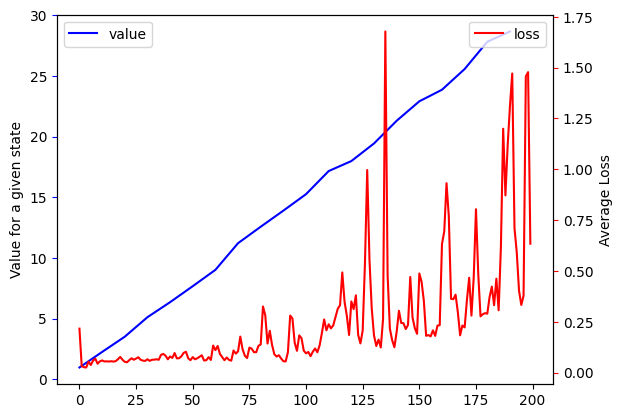

In [7]:
specific_values,avg_losses = train()
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots()
ax1.plot([x[0] * 10 for x in enumerate(specific_values)],specific_values,color='b',label='value')
ax1.set_ylabel('Value for a given state')
ax1.tick_params('y',color='b')
ax2 = ax1.twinx()
ax2.plot([x[0] for x in enumerate(avg_losses)],avg_losses,color='r',label='loss')
ax2.set_ylabel('Average Loss')
ax2.tick_params('y',color='r')
ax1.legend()
ax2.legend()
plt.show()

In [7]:
import gymnasium as gym
env = gym.make('CartPole-v1')

def demonstrate_policy(agent:ValueNet):
    cum_rewards = []
    for _ in range(10):
        state,_ = env.reset()
        tot = 0
        for t in range(505):
            action = agent.get_action(state)
            state,reward,terminated,truncated,_ = env.step(action)
            tot += reward
            if truncated or terminated:
                print(f'Stopped at time {t} due to', 'truncated' if truncated else 'terminated')
                break
        cum_rewards.append(tot)
    print('Average cumulative reward:',sum(cum_rewards)/len(cum_rewards))

In [11]:
demonstrate_policy(net)

Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Stopped at time 499 due to truncated
Average cumulative reward: 500.0


哈哈，刷爆了，是不是？可以看出，Value Iteration确实很强大。

你可能很奇怪，为什么训练的时候value没有很高，并且随着iteration直线上升？这是因为，很容易就可以学会一个“不倒”的策略，但是对于一个合理的策略而言，value完全取决于经历多少个time step；而你可以理解为一轮iteration大概就是“把若干time stamp连接到一起”。因此，训练的iteration越多，value就越高。注意这并非是常态，而是这里的任务过于简单了导致的。实际上，如果训练很长时间，value将稳定在500。

当然，必须再次强调，前面的方法违背了RL的基本原则。因此，我们接下来就来训练一个dynamic model。

##### Dynamic Model

为了简单起见，我们不去拟合$r(s,a)$了（因为它一直是1,也没什么可以拟合的）。我们只需要拟合next state对state, action的分布。但是既然我们已经知道这一环境是决定性的，不妨直接用一个决定性的分布代替。

接下来，我们通过随机的policy和环境交互来采集dynamic model的训练数据。注意我们这里的操作完全合法，没有走后门。为了证明这一点，我们删除自己的`CartPoleEnv`，只使用gym的接口。

In [8]:
del CartPoleEnv
env = gym.make('CartPole-v1')

In [9]:
@torch.no_grad()
def get_dynamic_dataloader(tot=5000):
    collected = []
    while len(collected) < tot:
        state,_ = env.reset()
        while True:
            action = env.action_space.sample()
            next_state,reward,terminated,truncated,_ = env.step(action)
            if terminated or truncated:
                collected.append((state,action,1,np.array([0,0,0,0],dtype=np.float32)))
                break
            else:
                collected.append((state,action,0,next_state))
            state = next_state
    def collate(datas):
        return {
            'states': torch.from_numpy(np.stack([data[0] for data in datas])).float().to(device),
            'actions': torch.tensor([data[1] for data in datas],dtype=torch.long).to(device),
            'terminated': torch.tensor([data[2] for data in datas],dtype=torch.float).to(device),
            'next_states': torch.from_numpy(np.stack([data[3] for data in datas])).to(device)
        }

    return DataLoader(dataset=collected,batch_size=32,shuffle=True,collate_fn=collate)

dl = get_dynamic_dataloader(8000)
valid_dl = get_dynamic_dataloader(2000)

In [23]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(5,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
        )
        self.next_state_head = nn.Linear(64,4)
        self.terminate_head = nn.Linear(64,1)

    def forward(self,s,a):
        # s: [batch,4]; a: [batch]
        concated = torch.cat([s,a.unsqueeze(-1).float()],dim=-1)
        feat = self.feature(concated)
        return self.next_state_head(feat),self.terminate_head(feat).reshape(-1)
    
    def get_loss(self,states,actions,next_states,terminated):
        pred_next_states,terminate_distr = self(states,actions)
        loss1 = F.binary_cross_entropy_with_logits(terminate_distr,terminated)
        loss2 = F.mse_loss(pred_next_states,next_states).mean(dim=0)
        return loss1 + loss2, loss1, loss2

    @torch.no_grad()
    def step(self,s,a):
        if not isinstance(a,torch.Tensor):
            a = torch.tensor(a,dtype=torch.float).to(device)
        next_state,terminate_logits = self(s,a)
        return next_state,1,(terminate_logits > 0).int(),False

In [24]:
dynamic_model = Model().to(device)
dynamic_opt = torch.optim.Adam(dynamic_model.parameters(),lr=1e-3,weight_decay=3e-5)
mean_losses = []
mean_valid_losses = []
for epoch in range(25):
    with tqdm.tqdm(dl) as bar:
        losses = []
        for item in bar:
            states = item['states']; actions = item['actions']; terminated = item['terminated']; next_states = item['next_states']
            loss,_,_ = dynamic_model.get_loss(states,actions,next_states,terminated)
            dynamic_opt.zero_grad()
            loss.backward()
            dynamic_opt.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Epoch {epoch}, Loss {sum(losses)/len(losses):.4f}')
    mean_losses.append(sum(losses)/len(losses))
    with torch.no_grad():
        valid_losses = []
        terminate_losses = []
        next_state_losses = []
        for item in valid_dl:
            states = item['states']; actions = item['actions']; terminated = item['terminated']; next_states = item['next_states']
            loss,terminate_loss,next_state_loss = dynamic_model.get_loss(states,actions,next_states,terminated)
            valid_losses.append(loss.detach().cpu().item())
            terminate_losses.append(terminate_loss.detach().cpu().item())
            next_state_losses.append(next_state_loss.detach().cpu().item())
        print('Validation loss:',sum(valid_losses)/len(valid_losses),'; Terminate loss:',sum(terminate_losses)/len(terminate_losses),'; Next state loss:',sum(next_state_losses)/len(next_state_losses))
    mean_valid_losses.append(sum(valid_losses)/len(valid_losses))

Epoch 0, Loss 0.9104:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 0, Loss 0.3657: 100%|██████████| 251/251 [00:01<00:00, 189.41it/s]


Validation loss: 0.1923288686999253 ; Terminate loss: 0.1565530456247784 ; Next state loss: 0.03577582285340343


Epoch 1, Loss 0.1761: 100%|██████████| 251/251 [00:01<00:00, 216.88it/s]


Validation loss: 0.1628539106912083 ; Terminate loss: 0.13269223970553232 ; Next state loss: 0.03016167120372374


Epoch 2, Loss 0.1587: 100%|██████████| 251/251 [00:00<00:00, 254.51it/s]


Validation loss: 0.15239803495979498 ; Terminate loss: 0.12422546614257116 ; Next state loss: 0.028172569264406488


Epoch 3, Loss 0.1475: 100%|██████████| 251/251 [00:01<00:00, 220.48it/s]


Validation loss: 0.13340495834274899 ; Terminate loss: 0.10874064532773835 ; Next state loss: 0.02466431273413556


Epoch 4, Loss 0.1345: 100%|██████████| 251/251 [00:01<00:00, 241.06it/s]


Validation loss: 0.11871062774979879 ; Terminate loss: 0.09614274650812149 ; Next state loss: 0.02256788184038467


Epoch 5, Loss 0.1215: 100%|██████████| 251/251 [00:01<00:00, 228.37it/s]


Validation loss: 0.11071060951207838 ; Terminate loss: 0.08882398155355264 ; Next state loss: 0.021886628213530733


Epoch 6, Loss 0.1089: 100%|██████████| 251/251 [00:00<00:00, 269.87it/s]


Validation loss: 0.09582794815420158 ; Terminate loss: 0.07637860448587508 ; Next state loss: 0.019449343705283745


Epoch 7, Loss 0.0979: 100%|██████████| 251/251 [00:01<00:00, 248.44it/s]


Validation loss: 0.08994412173827489 ; Terminate loss: 0.07123551164413729 ; Next state loss: 0.018708610500667303


Epoch 8, Loss 0.0905: 100%|██████████| 251/251 [00:01<00:00, 233.51it/s]


Validation loss: 0.08341858556701078 ; Terminate loss: 0.06527296566064396 ; Next state loss: 0.018145620109631666


Epoch 9, Loss 0.0852: 100%|██████████| 251/251 [00:00<00:00, 258.92it/s]


Validation loss: 0.08301051176847919 ; Terminate loss: 0.06573930367945678 ; Next state loss: 0.0172712079818464


Epoch 10, Loss 0.0812: 100%|██████████| 251/251 [00:00<00:00, 270.35it/s]


Validation loss: 0.07630924889374346 ; Terminate loss: 0.06031258424950971 ; Next state loss: 0.015996664965761794


Epoch 11, Loss 0.0778: 100%|██████████| 251/251 [00:01<00:00, 243.40it/s]


Validation loss: 0.07539673454482995 ; Terminate loss: 0.06035178104445102 ; Next state loss: 0.015044953215808149


Epoch 12, Loss 0.0742: 100%|██████████| 251/251 [00:01<00:00, 238.27it/s]


Validation loss: 0.0740230515126198 ; Terminate loss: 0.058903232431187044 ; Next state loss: 0.015119819384482171


Epoch 13, Loss 0.0720: 100%|██████████| 251/251 [00:00<00:00, 268.71it/s]


Validation loss: 0.07105260886370189 ; Terminate loss: 0.05667931188844026 ; Next state loss: 0.014373296829280518


Epoch 14, Loss 0.0713: 100%|██████████| 251/251 [00:00<00:00, 261.82it/s]


Validation loss: 0.06755397321715478 ; Terminate loss: 0.054146570811373376 ; Next state loss: 0.013407401633374984


Epoch 15, Loss 0.0679: 100%|██████████| 251/251 [00:01<00:00, 235.19it/s]


Validation loss: 0.07111688413184196 ; Terminate loss: 0.05703328841084999 ; Next state loss: 0.014083595510335669


Epoch 16, Loss 0.0671: 100%|██████████| 251/251 [00:01<00:00, 209.34it/s]


Validation loss: 0.06687076424159819 ; Terminate loss: 0.054058517310916196 ; Next state loss: 0.01281224715519726


Epoch 17, Loss 0.0635: 100%|██████████| 251/251 [00:01<00:00, 235.07it/s]


Validation loss: 0.06673650986086281 ; Terminate loss: 0.05383673658971453 ; Next state loss: 0.012899773740505298


Epoch 18, Loss 0.0638: 100%|██████████| 251/251 [00:01<00:00, 242.30it/s]


Validation loss: 0.0775176699731558 ; Terminate loss: 0.06301487543221031 ; Next state loss: 0.014502794200938845


Epoch 19, Loss 0.0622: 100%|██████████| 251/251 [00:01<00:00, 235.17it/s]


Validation loss: 0.06575093600928547 ; Terminate loss: 0.05335646194391071 ; Next state loss: 0.012394473575691263


Epoch 20, Loss 0.0600: 100%|██████████| 251/251 [00:01<00:00, 236.76it/s]


Validation loss: 0.06412809426870404 ; Terminate loss: 0.05191769167071297 ; Next state loss: 0.012210402767994396


Epoch 21, Loss 0.0590: 100%|██████████| 251/251 [00:01<00:00, 240.91it/s]


Validation loss: 0.0629559794943484 ; Terminate loss: 0.05106007764189844 ; Next state loss: 0.01189590189033114


Epoch 22, Loss 0.0582: 100%|██████████| 251/251 [00:01<00:00, 209.90it/s]


Validation loss: 0.06969620161948518 ; Terminate loss: 0.057094209894005744 ; Next state loss: 0.012601991790154624


Epoch 23, Loss 0.0572: 100%|██████████| 251/251 [00:01<00:00, 229.73it/s]


Validation loss: 0.061333139029715864 ; Terminate loss: 0.04922389607536533 ; Next state loss: 0.012109243498545967


Epoch 24, Loss 0.0559: 100%|██████████| 251/251 [00:01<00:00, 246.99it/s]


Validation loss: 0.06016261482404338 ; Terminate loss: 0.04860841778535691 ; Next state loss: 0.011554197083035159


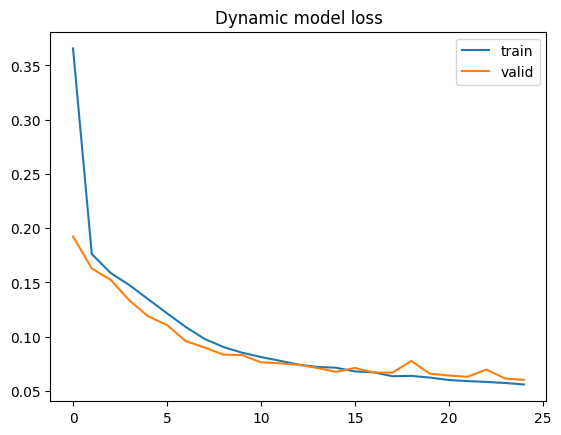

In [25]:
import matplotlib.pyplot as plt 
plt.plot(list(range(len(mean_losses))),mean_losses,label='train')
plt.plot(list(range(len(mean_valid_losses))),mean_valid_losses,label='valid')
plt.title('Dynamic model loss')
plt.legend()
plt.show()

看起来，loss的下降还算稳定，并且没有很严重的过拟合。一切还算顺利。

其实，严格上来说，我们还需要训练一个模型模拟`env.reset()`返回的initial state $s_0$的分布。但为了简化讨论，我们忽略这一点，直接还是使用`env.reset`。接下来，让我们重新利用自己的dynamic model来训练agent。我们只需要修改收集rollout的函数即可。

需要注意，既然现在我们完全不清楚MDP的内部，我们就不能像之前一样指定训练的state了。相反，我们使用之前训练dynamic model的数据来取state。

In [26]:
states = torch.cat([item['states'] for item in dl],dim=0)
states = [states[i] for i in range(states.shape[0])]
states = states[:1000]
print('Number of states:',len(states))

Number of states: 1000


In [27]:
transitions = []
for state in states:
    out = []
    actions = torch.tensor([0,1],dtype=torch.float).to(device)
    for action in [0,1]:
        # sample from our dynamic model
        next_state,_,terminated,_ = dynamic_model.step(state,action)
        out.append((action,next_state,reward,terminated))
    transitions.append((state,out))

print('Collected',len(transitions),'transitions')

Collected 1000 transitions


然后，把上面的工作重新做一遍：

In [28]:
class ValueNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(4,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        return self.mlp(x)
    
    @torch.no_grad()
    def get_action(self,x):
        if not isinstance(x,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float).to(device)
        best_act = None; best_val = -float('inf')
        for action in [0,1]:
            next_state,_,terminated,_ = dynamic_model.step(x,action)
            if terminated:
                val = 0
            else:
                val = self(next_state).cpu().item()
            if val > best_val:
                best_val = val
                best_act = action
        return best_act

In [29]:
net = ValueNet().to(device)
target_net = ValueNet().to(device).requires_grad_(False)
target_net.load_state_dict(net.state_dict())
ALPHA = 0.1
optimizer = torch.optim.Adam(net.parameters(),lr=1e-2,weight_decay=3e-5)

specific_values,avg_losses = train(num_iterations=200)

We use the following state for monitoring Value:
 [-0.02531704  0.0003996   0.00438498 -0.04956347]


  0%|          | 0/200 [00:00<?, ?it/s]

Value of the given state: 19.26; Avg Loss: 3.2761: 100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


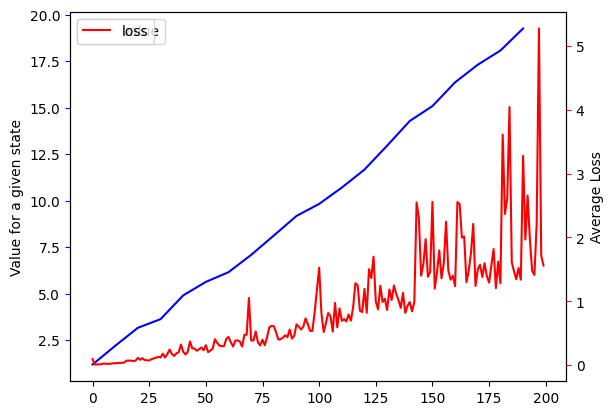

In [30]:
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots()
ax1.plot([x[0] * 10 for x in enumerate(specific_values)],specific_values,color='b',label='value')
ax1.set_ylabel('Value for a given state')
ax1.tick_params('y',color='b')
ax2 = ax1.twinx()
ax2.plot([x[0] for x in enumerate(avg_losses)],avg_losses,color='r',label='loss')
ax2.set_ylabel('Average Loss')
ax2.tick_params('y',color='r')
ax1.legend()
ax2.legend()
plt.show()

我们发现一个很大的问题：这里的loss上升的很快（回顾上一张图，可以看到代表loss的红线平均下来是不太动的，而在这里急剧地上升）。而且这还是loss最小的一批state，因此可以想象到Value Iteration的目标存在着很大（且随着iteration而增大）的误差。而且不管如何调节超参数，似乎都不行。

这让我们有些不安，是否意味着要寄了？

In [31]:
def demonstrate_policy(agent:ValueNet):
    cum_rewards = []
    for _ in range(10):
        state,_ = env.reset()
        tot = 0
        for t in range(505):
            action = agent.get_action(state)
            state,reward,terminated,truncated,_ = env.step(action)
            tot += reward
            if truncated or terminated:
                print(f'Stopped at time {t} due to', 'truncated' if truncated else 'terminated')
                break
        cum_rewards.append(tot)
    print('Average cumulative reward:',sum(cum_rewards)/len(cum_rewards))

In [32]:
demonstrate_policy(net)

Stopped at time 10 due to terminated
Stopped at time 9 due to terminated
Stopped at time 8 due to terminated
Stopped at time 8 due to terminated
Stopped at time 10 due to terminated
Stopped at time 10 due to terminated
Stopped at time 10 due to terminated
Stopped at time 10 due to terminated
Stopped at time 11 due to terminated
Stopped at time 10 due to terminated
Average cumulative reward: 10.6


果然！但差的程度还是远远糟于我们的想象。为什么会这样？我们接下来应该怎么办？

首先，我们来看看，我们的dynamic model做得到底有多好呢？我们可以做一个动画的演示：

In [33]:
import gymnasium as gym
import random
from utils_0_intro import compare_videos,CartPoleEnv
def get_action(state): # Copied from TrivialAgent
    _,_,theta,omg = state
    if theta < 0 and omg < 0:
        return 0
    if theta > 0 and omg > 0:
        return 1
    return random.choice([0,1])


frames1 = [];frames2 = []
env = gym.make('CartPole-v1',render_mode='rgb_array')
fooenv = CartPoleEnv(render_mode='rgb_array')
fooenv.reset()
state1,_ = env.reset()
state2 = torch.tensor(state1,dtype=torch.float).to(device)

for t in range(501):
    frames1.append(env.render())
    fooenv.state = state2.cpu().numpy()
    frames2.append(fooenv.render())

    action = get_action(state1)

    state1, reward, terminated, truncated, info = env.step(action)

    state2,_,terminated2,_ = dynamic_model.step(state2,torch.tensor(action,dtype=torch.float).to(device))

    if terminated or truncated:
        print('The real environment is stopped at time',t)
    if terminated2:
        print('The model terminated at time',t)
    if terminated or terminated2 or truncated:
        break

print('Generating Video, this may take around 30 seconds...')
compare_videos(frames1,frames2,title1='Original',title2='Predicted')

The real environment is stopped at time 499
Generating Video, this may take around 30 seconds...


可以看到，虽然loss很低，但是在几十步之后模型就停止了，而真正的环境还完全活着！并且，在大约30步的时候，模型就出现了很大的偏差。

为什么会这样？这其实很好理解！比如你发现我们的terminated的cross entropy loss大约是0.05，这意味着每一次就有 $1-e^{0.05}$ 的概率犯错误；这样，在大约20轮后，就有很高的概率犯错误了。因此在真正的环境还处于良好状态的时候，模型就有可能认为这一状态应该停止。

因此，我们不应该完全利用模型，而是应该结合之前采集的数据和模型的数据。让我们再来试一试！

> 你可能觉得这些讨论仍然无法解释loss飞速上升的问题？的确，这里很难找到一个绝对的原因。但是，可以推测，因为模型比较差，环境很容易随便就终止了，这样agent就不清楚

# Backup

In [21]:
env = gym.make('CartPole-v1')

def demonstrate_policy(agent:ValueNet):
    cum_rewards = []
    for _ in range(10):
        state,_ = env.reset()
        state = torch.from_numpy(state).to(device)
        tot = 0
        for t in range(505):
            action = agent.get_action(state)
            state,reward,terminated,_ = dynamic_model.step(state,torch.tensor(action,dtype=torch.float).to(device))
            tot += reward
            if terminated:
                print(f'Stopped at time {t} due to terminated')
                break
        cum_rewards.append(tot)
    print('Average cumulative reward:',sum(cum_rewards)/len(cum_rewards))

demonstrate_policy(net)

Stopped at time 103 due to terminated
Stopped at time 98 due to terminated
Stopped at time 41 due to terminated
Stopped at time 8 due to terminated
Stopped at time 8 due to terminated
Stopped at time 50 due to terminated
Stopped at time 60 due to terminated
Stopped at time 78 due to terminated
Stopped at time 26 due to terminated
Stopped at time 27 due to terminated
Average cumulative reward: 50.9
